    1.	Считайте файл и создайте Spark DataFrame

In [1]:
from pyspark.sql import SparkSession

# Создаем SparkSession
spark = SparkSession.builder.appName("CSV to DataFrame").getOrCreate()


csv_file_path = "130/2/2.csv"

df = spark.read.csv(csv_file_path, header=True, inferSchema=True)


df.show()

+----------+--------------------+-----+--------+-----------------+--------------------+---------------+---------------+------+--------------------+
|product_id|                name|price|quantity|         category|         description|production_date|expiration_date|rating|              status|
+----------+--------------------+-----+--------+-----------------+--------------------+---------------+---------------+------+--------------------+
|         1|            Антрекот| 8782|      89|             Мясо|Отличается высоки...|     2015-02-12|     2030-06-16|  2.62|     Awaiting Review|
|         2|          Пензенская| 5840|     234|          Напитки|Отличается высоко...|     1992-01-01|     1994-01-15|  3.96|            Refunded|
|         3|      Куриные грудки| 3496|      70|             Мясо|Отличается высоко...|     2011-02-03|     2011-05-01|  1.12|        Out of Stock|
|         4|Каша из дробленой...| 1857|     203|          Бакалея|Придает блюдам ос...|     2016-07-09|     2023

2.	Выполните группировку по колонке категориальных данных category, 
    а также приведенные агрегации по колонке price (частота, среднее, максимальное, минимальное, процент от общего числа).

In [4]:
from pyspark.sql.functions import mean, max, min, col, count


# Общее количество строк в DataFrame
total_count = df.count()

# Группировка по колонке 'category' и применение агрегаций по колонке 'price'
grouped = df.groupby('category').agg(
    count('price').alias('frequency'),
    mean('price').alias('mean'),
    max('price').alias('max'),
    min('price').alias('min')
)

# Добавление столбца с процентом от общего числа
grouped = grouped.withColumn('percent_of_total', (col('frequency') / total_count) * 100)

# Показ результата
grouped.show()

+-----------------+---------+------------------+----+---+------------------+
|         category|frequency|              mean| max|min|  percent_of_total|
+-----------------+---------+------------------+----+---+------------------+
|             Мясо|      101| 5270.316831683168|9966|160|12.672521957340024|
|Молочные продукты|      124| 5217.403225806452|9928|121|15.558343789209536|
|            Овощи|      108| 5585.240740740741|9937|162| 13.55081555834379|
|           Фрукты|       86|5539.2441860465115|9949|153|10.790464240903388|
|  Товары для дома|      110| 4942.027272727273|9621|137|13.801756587202007|
|          Напитки|      124| 5099.443548387097|9995|229|15.558343789209536|
|          Бакалея|      144| 4755.402777777777|9989|184| 18.06775407779172|
+-----------------+---------+------------------+----+---+------------------+



    3.	Постройте круговую диаграмму, отражающую общее распределение по значениям категориальной колонки.

 [Row(category='Мясо'), Row(category='Молочные продукты'), Row(category='Овощи'), Row(category='Фрукты'), Row(category='Товары для дома'), Row(category='Напитки'), Row(category='Бакалея')]


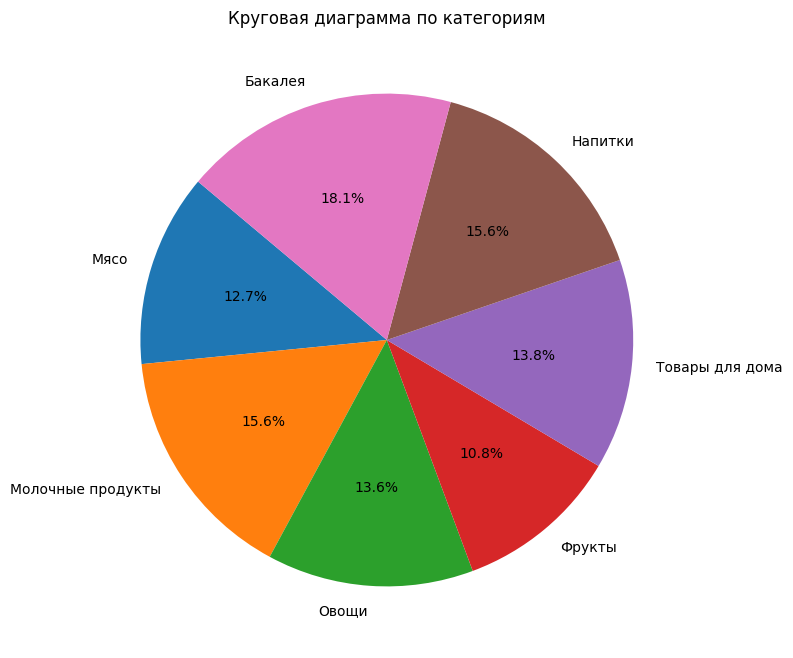

In [ ]:
import matplotlib.pyplot as plt


categories = grouped.select('category').collect()
frequencies = grouped.select('frequency').collect()

categories_list = [row['category'] for row in categories]
frequencies_list = [row['frequency'] for row in frequencies]

print("", categories)

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(frequencies_list, labels=categories_list, autopct='%1.1f%%', startangle=140)
plt.title('Круговая диаграмма по категориям')
plt.show()

4.  Запишите полученные данные (п. 2) в файл JSON

In [13]:
file_path = "130/2/statistic.json"

# Запись Статистики в JSON файл
grouped.toPandas().to_json(file_path, orient="records", lines=True)